# Gausssian Process for Classification - GPC
In Gussian Process Regrassion we had an analyticaly traceable posterior and prediction distribution but as we will see that is not the case with GPC and we will need to use approximating methods for derving terms for these distributions\footnote{hi}. In our first step we will try GP in binary classification case. Similar to GPR we will use a gaussian latent function but for likelihood we will squash the values with another response function. There can be multiple choices for the response function such as logistic function and cumulative gaussian (probit), and here we will use the probit. 

We compress the output of a GP (over the latent function f(x)) to the range [0:1] through probit function and the result will denote the class membership probabilities. We first need to compute the distribution of the latent variable:

\begin{equation}
p(f_* | f) = \int p(f_*|X,x_*,f)p(f|X,y)df=N(K_*K^{-1}\hat{f},K_{**}-K_*(K')^{-1}K_*^T)
\end{equation}

Then we want the class membership probabilities, here $\pi_*=\Phi (f_*)$, whose expected value will be:

\begin{equation}
\bar{\pi_*} = \int \pi(f_*)p(f_*|f)df_*
\end{equation}

Finding $\hat f$ and $K'$:

\begin{equation}
p(f|X,y) = \frac{p(y|f)p(f|x)}{p(y|x)}
\end{equation}

P(f|x,y) does not have an analytic form so we use Laplace approximation by pretending that it is a guassian:

\begin{equation}
p(f|x,y) \sim q(f|x,y) = N(\hat f, A^{-1})
\end{equation}

we have the probit likelihood $p(y|f) = \prod^n_{i=1} p(y_i|f_i) = \Phi(yf)$ and for p(f|x) we would like values that maximize the posterior probability p(f|x,y). So we set derivative of its logarithem to zero 

\begin{align*}
\Psi(f) \triangleq log p(y|f) + log p(f|X),\\
\nabla \Psi(f) = \nabla logp(y|f) - K^{-1}f,\\
\nabla \nabla \Psi(f) = \nabla \nabla logp(y|f) - K^{-1} = -W -K^{-1},\\
\end{align*}


and gain a recursive equation 

\begin{equation}
\hat f = K \nabla log p(y|\hat f)
\end{equation}

We use newton's method with f_0 = 0 and equation 3.18 from GPML

\begin{equation}
f^{new}=(K^{-1}+W)^{-1}(Wf+\nabla logp(y|f) )
\end{equation}

and in the end we have (eq. 3.20 GPML)

\begin{equation}
q(f|X,y) = N(\hat f, (W+K^{-1})^{-1})
\end{equation}

For prediction we have (cumulative Gausian function for squashing)
$$
\begin{align*}
p(f_* | f) = N(K_*K^{-1}\hat{f},K_{**}-K_*(K')^{-1}K_*^T)\\
K' = K + W^{-1}\\
\bar{\pi_*} \stackrel{GMPL 3.9}{=} \Phi \big(\frac{\bar{f_*}}{\sqrt{1+var(f_*)}}\big)
\end{align*}
$$

Further numerically stable implementation considerations can be found in section 3.4.3 of GPML book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fmin
from scipy.linalg import cholesky, cho_solve, inv

#np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

%matplotlib inline
%load_ext autoreload
%autoreload 2

We will define kernel function here:

In [2]:
def get_kernel(X1,X2,sigmaf,l,sigman):
    k = lambda x1,x2,sigmaf,l,sigman:(sigmaf**2)*np.exp(-(1/float(2*(l**2)))*np.dot((x1-x2),(x1-x2).T)) + (sigman**2);
    K = np.zeros((X1.shape[0],X2.shape[0]))
    for i in range(0,X1.shape[0]):
        for j in range(0,X2.shape[0]):
            if i==j:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,sigman);
            else:
                K[i,j] = k(X1[i,:],X2[j,:],sigmaf,l,0);
    return K

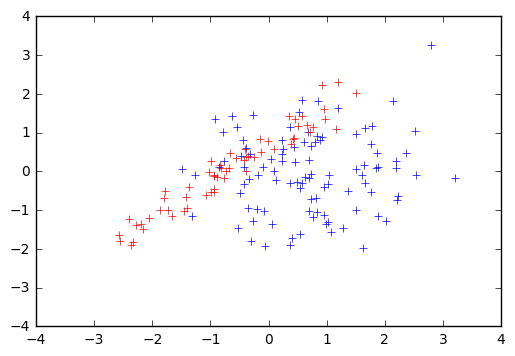

In [37]:
n1 = 100; n2 = 60; # number of elements in each class

S1 = np.eye(2); S2 = np.array([[1,0.95],[0.95,1]])
m1 = np.array([0.75, 0]);m2 = np.array([-0.75, 0])


x1 = np.random.multivariate_normal(m1,S1,n1); y1 = -1*np.ones([n1,1]);
x2 = np.random.multivariate_normal(m2,S2,n2); y2 = np.ones([n2,1]);

x = np.concatenate((x1[0:50,:], x2[0:30,:]), axis=0);
y = np.concatenate((y1[0:50,:], y2[0:30,:]), axis=0);

x_test = np.concatenate((x1[50:,:], x2[30:,:]), axis=0); 
y_test = np.concatenate((y1[50:,:], y2[30:,:]), axis=0); 

plt.plot(x[y[:,0]==1,0], x[y[:,0]==1,1], 'r+', x[y[:,0]==-1,0], x[y[:,0]==-1,1], 'b+')
plt.plot(x_test[y_test[:,0]==1,0], x_test[y_test[:,0]==1,1], 'r+', x_test[y_test[:,0]==-1,0], x_test[y_test[:,0]==-1,1], 'b+')

plt.axis([-4, 4, -4, 4])

plt.show()

## Predictive gaussian parameter finding (with gaussian cumulative likelihood)
based on algo 3.1 page 65 GPML book

In [38]:
sigmaf = 1; l = 1; sigman = 1;# non optimum values

K = get_kernel(x,x,sigmaf,l,sigman);
# K = K + np.finfo(float).eps*np.eye(x.shape[0]);#for stability
K = nearestSPD(K);
f = np.zeros_like(y);

old_log_marg = np.inf; new_log_marg = 0; 
it = 0; maxit=10000;
for it in range(maxit): #newton iterations
    npf = norm.pdf(f); cpyf = norm.cdf(y*f);
    
    dlp = y*npf/cpyf #3.16
    d2lp = -npf**2/cpyf**2 - y*f*npf/cpyf # 3.16

    W = -1.*d2lp; sW = np.sqrt(W)
    B = np.eye(x.shape[0])+sW*K*sW #B=I+sqrt(W)*K*sqrt(W)
    
    #B = make_PD(B)
    B = nearestSPD(B)
    
    L = cholesky(B, lower=True)
    b = W*f + dlp; # 3.18 part 1
    a = b - sW * cho_solve((L, True),np.dot(sW*K,b)) # b - sW.*(L'\(L\(sW.*K*b)))
    f = K.dot(a)
    
    new_log_marg = -0.5 * a.T.dot(f) \
                + np.log(norm.cdf(y*f)).sum() \
                - np.log(np.diag(L)).sum()
    if it%10==0: 
        print '%e'%abs(new_log_marg - old_log_marg)
    if abs(new_log_marg - old_log_marg) < 1e-3: # need to adapt step sizes
        print('FOUND! %f at %d iteration!'%(abs(new_log_marg - old_log_marg),it))
        break
    else:
        old_log_marg = new_log_marg;
    
fhat = f

inf
FOUND! 0.000455 at 6 iteration!


C:\Users\nimaq\Anaconda2\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in sqrt
C:\Users\nimaq\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\nimaq\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: RuntimeWarning: invalid value encountered in less


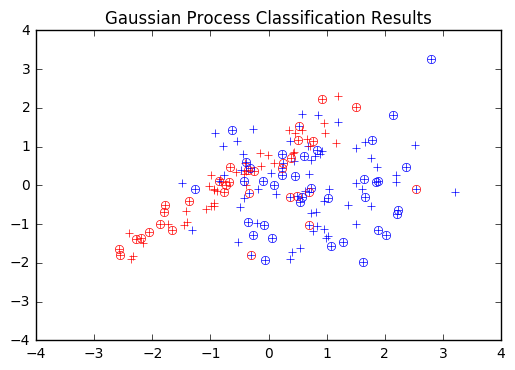

In [49]:
npf = norm.pdf(fhat); cpyf = norm.cdf(y*fhat);
    
lp = np.log(cpyf);
dlp = y*npf/cpyf #3.16
d2lp = -npf**2/cpyf**2 - y*f*npf/cpyf # 3.16

W = -1.*d2lp; sW = np.sqrt(W)
B = np.eye(x.shape[0])+sW*K*sW #B=I+sqrt(W)*K*sqrt(W)   
#B = make_PD(B)
B = nearestSPD(B)
L = cholesky(B, lower=True)
    
K_s = get_kernel(x_test, x, sigmaf, l, sigman);
K_ss = get_kernel(x_test, x_test, sigmaf, l, sigman);

fs = np.dot(K_s.T,dlp);
v = np.dot(inv(L),(sW*K_s));

y_test_var = np.diag(K_ss - np.dot(v.T,v));# uncertainty
y_test_mean = norm.cdf(np.real(np.divide(fs[:,0],np.sqrt(1+y_test_var))));# best prediction

plt.plot(x[y[:,0]==1,0], x[y[:,0]==1,1], 'r+', x[y[:,0]==-1,0], x[y[:,0]==-1,1], 'b+')
plt.plot(x_test[y_test[:,0]==1,0], x_test[y_test[:,0]==1,1], 'r+', x_test[y_test[:,0]==-1,0], x_test[y_test[:,0]==-1,1], 'b+')


plt.plot(x_test[y_test_mean>=0.5,0], x_test[y_test_mean>=0.5,1], 'o', markerfacecolor='None',markeredgecolor='r');
plt.plot(x_test[y_test_mean<0.5,0], x_test[y_test_mean<0.5,1], 'o', markerfacecolor='None',markeredgecolor='b');

plt.title('Gaussian Process Classification Results')
plt.axis([-4, 4, -4, 4])
plt.show()


In [6]:
def make_PD(A):
    # gets a matrix and turns it into positive definit
    for i in range(100):
        print i,
        try:
            L = cholesky(A, lower=True);
            print('positive def at %d iters\n'%i);
            return A
        except:
            A = A + np.finfo(float).eps*np.eye(A.shape[0]);#for stability
            continue
    return A

In [19]:
from numpy.linalg import svd, eig
from numpy.linalg import cholesky as chol

def nearestSPD(A):

    r,c = A.shape;

    B = (A + A.T)/2;
    [U,Sigma,V] = svd(B);
    Sigma = Sigma*np.eye(Sigma.size);
    V = V.T
    H = np.dot(V,np.dot(Sigma,V.T));
    Ahat = (B+H)/2;

    Ahat = (Ahat + Ahat.T)/2;

    # test that Ahat is in fact PD. if it is not so, then tweak it just a bit.
    k = 0;
    while 1:
        k = k + 1;
        try:
            cholesky(Ahat, lower=True);
            return Ahat
        except:
            mineig = eig(Ahat)[0].min().real
            Ahat = Ahat + (-1*mineig*k**2 + np.spacing(mineig))*np.eye(A.shape[0]);
    return Ahat
#an implementation of doi:10.1016/0024-3795(88)90223-6

#### References
###### Nicholas J. Higham, Computing a nearest symmetric positive semidefinite matrix, doi:10.1016/0024-3795(88)90223-6
###### Gaussian Processes for Machine Learning Carl Edward Rasmussen and Christopher K. I. Williams The MIT Press, 2006.